In [275]:
%autoreload 2

from VMTest import *

In [276]:
import json
from networkx.readwrite import json_graph

def removeDefaults(df):
    defaults = list(loadSQL('defaults','allEdges')['subreddit'])
    subset = df[~df['subreddit'].isin(defaults)].copy()
    
    return subset

def dropSingleEdges(G):
    edges = list(G.edges(data=True))
    single_edges = [edge for edge in edges if edge[2]['weight'] == 1]
    
    G.remove_edges_from(single_edges)
    
    return G

def removeIsolates(G):
    isolates = list(nx.isolates(G))
    G.remove_nodes_from(isolates)
    
    return G
    
def setAttributes(G):
    nx.set_node_attributes(G, 'group', 1)
    for n in G:
        G.nodes[n]['id'] = n
        
    return G

def subsetNet(G):
    G = dropSingleEdges(G)
    G = removeIsolates(G)
    G = setAttributes(G)
    
    return G
    
def saveGraphJson(G, filename):
    d = json_graph.node_link_data(G)
    json.dump(d, open(filename, 'w'))

In [23]:
def projectSub(df):
    top = df.subreddit.values
    bot = df.author.values
    
    top_unique, top_indices = sp.unique(top, return_inverse=True)
    bot_unique, bot_indices = sp.unique(bot, return_inverse=True)
    
    data = sp.ones(len(top))
    incidence = sp.sparse.coo_matrix((data, (top_indices, bot_indices)))
    adj = incidence.dot(incidence.T)
    
    G = add_edges_fast(top_unique, adj)
    
    return G

In [265]:
database_name = 'allEdges'
engine = get_engine(database_name)

subreddit = 'changemyview'
char = 'a'
query = """
        SELECT author, subreddit, weight
        FROM {0}
        WHERE (subreddit not in (SELECT subreddit FROM defaults))
        and (author in (select author
            FROM {0}
            WHERE (subreddit == '{1}')
            and (author not in (SELECT author FROM skipAuthors))))
        """.format(char, subreddit)

data = pd.read_sql_query(query, engine)

In [278]:
cmvAuthors = data[data['subreddit']=='changemyview'].author

In [280]:
data.columns = ['author','subreddit','value']
data = data[data['value']>1]
cmvNetwork = data[data['author'].isin(cmvAuthors)]
nonCMVNetwork = data[~data['author'].isin(cmvAuthors)]

## Basic Stats

In [281]:
print('CMV NETWORK')
print('There are', cmvNetwork.author.unique().shape[0], 'CMV authors across',
     cmvNetwork.subreddit.unique().shape[0], 'subreddits')
print()

print('Non-CMV NETWORK')
print('There are', nonCMVNetwork.author.unique().shape[0], 'non CMV authors across',
     nonCMVNetwork.subreddit.unique().shape[0], 'subreddits')

CMV NETWORK
There are 723 CMV authors across 2272 subreddits

Non-CMV NETWORK
There are 0 non CMV authors across 0 subreddits


In [187]:
cmvNetwork.value.describe()

count    12428.000000
mean         5.901110
std         22.350841
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       1055.000000
Name: value, dtype: float64

In [222]:
cmvCount = cmvNetwork.groupby('subreddit')['value'].count()
cmvSum = cmvNetwork.groupby('subreddit')['value'].sum()

noncmvCount = nonCMVNetwork.groupby('subreddit')['value'].count()
noncmvSum = nonCMVNetwork.groupby('subreddit')['value'].sum()

In [229]:
diff = pd.DataFrame({'cmv_authors':cmvCount,
                     'cmv_comments':cmvSum,
                     'noncmv_authors':noncmvCount,
                     'noncmv_comments':noncmvSum
                    }).fillna(0)

diff = diff[diff['cmv_authors']>0].drop('changemyview') # removing subreddits included by removed authors
diff['author_diff'] = diff['cmv_authors']/diff['noncmv_authors']
diff['comment_diff'] = diff['cmv_comments']/diff['noncmv_comments']
diff.head()

,cmv_authors,cmv_comments,noncmv_authors,noncmv_comments,author_diff,comment_diff
0xProject,1.0,6.0,8.0,39.0,0.125000,0.153846
2007scape,8.0,71.0,793.0,8286.0,0.010088,0.008569
240sx,1.0,4.0,9.0,92.0,0.111111,0.043478
2healthbars,1.0,4.0,45.0,115.0,0.022222,0.034783
2mad4madlads,1.0,3.0,14.0,32.0,0.071429,0.093750


In [230]:
diff.shape

(2271, 6)

In [264]:
diff.sort_values(['cmv_authors','noncmv_authors'], ascending=[False, True]).head()

,cmv_authors,cmv_comments,noncmv_authors,noncmv_comments,author_diff,comment_diff
politics,143.0,3349.0,4999.0,89250.0,0.028606,0.037524
PoliticalHumor,48.0,436.0,898.0,6406.0,0.053452,0.068061
technology,45.0,270.0,1167.0,6246.0,0.038560,0.043228
AdviceAnimals,44.0,377.0,985.0,4755.0,0.044670,0.079285
NoStupidQuestions,40.0,480.0,736.0,5979.0,0.054348,0.080281


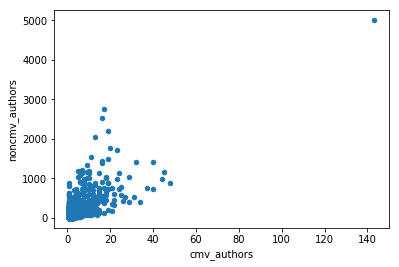

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

diff.plot('cmv_authors','noncmv_authors', kind='scatter');

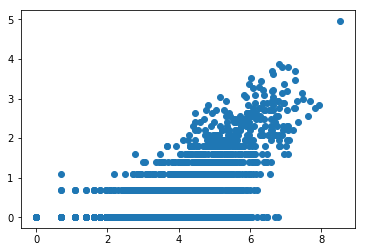

In [263]:
import numpy as np 

fig, ax = plt.subplots()

x = np.log(diff['noncmv_authors']+1)

y = np.log(diff['cmv_authors'])
ax.scatter(x, y);

# Producing Graphs

## Testing on Sample Network

In [175]:
def separateUpperQuartile(df, col):
    upper_bound = df.quantile(.75)[col]
    lq = s[s[col]<upper_bound]
    uq = s[s[col]>=upper_bound]
    
    return lq, uq

def removeUpperQuartileNodes(G):
    s = pd.DataFrame.from_dict(dict(G.degree()), orient='index')
    lq, uq = separateUpperQuartile(s, 0)
    
    G.remove_nodes_from(uq.index)

In [179]:
def makeNetworkGraph(data, filename):
    G = projectSub(data)
    G.remove_node('changemyview')
    removeUpperQuartileNodes(G)

    defaults = list(loadSQL('defaults','reference')['defaults'])
    G.remove_nodes_from(defaults) # too connected
    G.remove_node('politics') # too connected
    subset = subsetNet(G)

    saveGraphJson(subset, '{}.json'.format(filename))
    
makeNetworkGraph(nonCMV, 'noncmv')

In [130]:
df = nx.to_pandas_edgelist(subsetCMV)

In [131]:
df.sort_values('weight').tail()

,source,target,weight
22447,WTF,politics,29.0
24435,bestof,politics,36.0
1877,AdviceAnimals,politics,40.0
18055,PoliticalHumor,politics,45.0
30563,politics,technology,46.0


In [193]:
G = projectSub(cmvNetwork)

In [194]:
nx.degree(G)

DegreeView({'0xProject': 9, '2007scape': 106, '240sx': 52, '2healthbars': 169, '2mad4madlads': 57, '2meirl42meirl4meirl': 44, '2meirl4meirl': 189, '3DS': 97, '3Dprinting': 19, '3dshacks': 29, '40kLore': 17, '49ers': 15, '4PanelCringe': 96, '4chan': 315, '52weeksofcooking': 17, '72scale': 16, '7daystodie': 6, '911truth': 11, 'ADHD': 126, 'AMA': 44, 'AMDHelp': 11, 'ANormalDayInAmerica': 21, 'ANormalDayInRussia': 271, 'ATBGE': 358, 'ATC': 20, 'AVoid5': 14, 'AbandonedPorn': 182, 'Absurdism': 8, 'AcademicPsychology': 9, 'Acadiana': 17, 'AccidentalComedy': 22, 'AccidentalRacism': 169, 'Accounting': 4, 'Accutane': 2, 'ActLikeYouBelong': 172, 'ActionFigures': 11, 'AdventureCapitalist': 7, 'AdventurersLeague': 7, 'Advice': 147, 'AdviceAnimals': 676, 'AgainstHateSubreddits': 274, 'Agoraphobia': 25, 'AirBnB': 20, 'AirForce': 10, 'Alabama': 7, 'AllFantasyEverything': 48, 'AlliedHQ': 33, 'Allthewaythrough': 12, 'AlternativeAstronomy': 10, 'AmISexy': 121, 'AmItheAsshole': 21, 'AmazonMerch': 1, 'Amd'